In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import scipy
import tensorflow as tf
from tensorflow.keras import initializers
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 28
NUM_CLASSES = 10
NUM_CHANNELS = 1
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_weight_init"
PATH = ""

# Set seeds

In [0]:
run = "run3"
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_testc = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def MNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Train

In [10]:
models = []
accuracies = []
predictions = []
initializer = ["Zero","Ones","Random Normal","Random Uniform","Identity","Orthogonal","Glorot Normal","Glorot Uniform"]
for i in range(len(initializer)):

    print(f"Train model {i}")
    print(f"Weight init method: {initializer[i]} ")
    model = MNISTmodel(IMAGE_SIZE,NUM_CLASSES,NUM_CHANNELS)
    
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            if(initializer[i] == "Zero"):
                layer.kernel_initializer = initializers.Zeros()
            elif(initializer[i] == "Ones"):
                layer.kernel_initializer = initializers.Ones()
            elif(initializer[i] == "Random Normal"):
                layer.kernel_initializer = initializers.RandomNormal()
            elif(initializer[i] == "Random Unifrom"):
                layer.kernel_initializer = initializers.RandomUniform()
            elif(initializer[i] == "Identity"):
                layer.kernel_initializer = initializers.Identity()
            elif(initializer[i] == "Orthogonal"):
                layer.kernel_initializer = initializers.Orthogonal()
            elif(initializer[i] == "Glorot Normal"):
                layer.kernel_initializer = initializers.GlorotNormal()
            elif(initializer[i] == "Glorot Unifrom"):
                layer.kernel_initializer = initializers.GlorotUnifrom()
          
    es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)
    model.fit(x_train,y_train,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              validation_data = (x_val,y_val),
              shuffle = True,
              callbacks=[es])
    models.append(model)
    y_prob = model.predict(x_test) 
    predictions.append(y_prob.argmax(axis=-1))
    acc = model.evaluate(x_test,y_testc)[1]
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")


Train model 0
Weight init method: Zero 
Train on 48000 samples, validate on 12000 samples
Epoch 1/9999
48000/48000 [==============================] - 5s 102us/step - loss: 2.2536 - accuracy: 0.1469 - val_loss: 2.2540 - val_accuracy: 0.2584
Epoch 2/9999
48000/48000 [==============================] - 4s 77us/step - loss: 2.0958 - accuracy: 0.3349 - val_loss: 2.0326 - val_accuracy: 0.3536
Epoch 3/9999
48000/48000 [==============================] - 4s 77us/step - loss: 1.9452 - accuracy: 0.3796 - val_loss: 1.8768 - val_accuracy: 0.3853
Epoch 4/9999
48000/48000 [==============================] - 4s 76us/step - loss: 1.8181 - accuracy: 0.4025 - val_loss: 1.7635 - val_accuracy: 0.4176
Epoch 5/9999
48000/48000 [==============================] - 4s 77us/step - loss: 1.7185 - accuracy: 0.4295 - val_loss: 1.6738 - val_accuracy: 0.4425
Epoch 6/9999
48000/48000 [==============================] - 4s 76us/step - loss: 1.6412 - accuracy: 0.4504 - val_loss: 1.6087 - val_accuracy: 0.4646
Epoch 7/9999
48

# Results

# Accuracy vs Weight initialization method

In [11]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df["weight_init_method"] = initializer
display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy_"+ run + ".csv")

,Accuracy,weight_init_method
0,0.7627,Zero
1,0.7724,Ones
2,0.7837,Random Normal
3,0.7621,Random Uniform
4,0.7611,Identity
5,0.7575,Orthogonal
6,0.7620,Glorot Normal
7,0.7758,Glorot Uniform


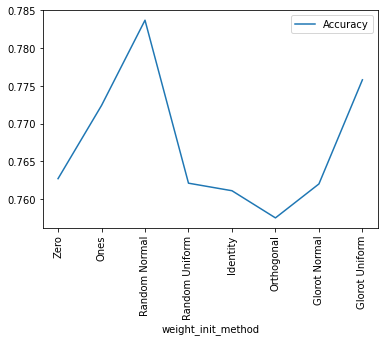

In [12]:
import matplotlib.pyplot as plt

accuracy_df.plot(x="weight_init_method", y="Accuracy",rot = 90)

plt.show()


In [13]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,y_test)])

100%|██████████| 8/8 [00:00<00:00, 190.13it/s]


## Correlation between models

In [14]:
correlation_matrix = []

for ix, x in enumerate(classified):
  row = []
  
  for iy, y in enumerate(classified):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df.columns = initializer
correlation_matrix_df.index = initializer
display(correlation_matrix_df)
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))
correlation_matrix_df.to_csv(PATH + MODEL_NAME + "_correlation_matrix_" + run + ".csv")

,Zero,Ones,Random Normal,Random Uniform,Identity,Orthogonal,Glorot Normal,Glorot Uniform
Zero,NaN,0.648582,0.639264,0.621301,0.652174,0.704494,0.702771,0.676321
Ones,0.648582,NaN,0.626609,0.649494,0.657354,0.651115,0.639752,0.653492
Random Normal,0.639264,0.626609,NaN,0.623708,0.618161,0.650834,0.633191,0.664524
Random Uniform,0.621301,0.649494,0.623708,NaN,0.628236,0.644453,0.632438,0.644005
Identity,0.652174,0.657354,0.618161,0.628236,NaN,0.648217,0.646186,0.640692
Orthogonal,0.704494,0.651115,0.650834,0.644453,0.648217,NaN,0.696823,0.653053
Glorot Normal,0.702771,0.639752,0.633191,0.632438,0.646186,0.696823,NaN,0.657861
Glorot Uniform,0.676321,0.653492,0.664524,0.644005,0.640692,0.653053,0.657861,NaN


Average correlation: 0.6501823095907168


# Ensemble accuracy

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

In [16]:
print("Accuracy of ensemble: " + str(predict(models, x_test, y_testc)))

100%|██████████| 8/8 [00:04<00:00,  1.90it/s]

Accuracy of ensemble: 0.7926
